# Классификация сигналов EEG

Данные взяты отсюда https://www.kaggle.com/datasets/harunshimanto/epileptic-seizure-recognition?resource=download

Необходимо классифицировать сигналы EEG по наличию приступа эпилепсии (y == 1)

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from scipy.fftpack import fft
from scipy.signal import find_peaks
import pywt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.transform import resize
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import tsfel

from tqdm.auto import tqdm

## 1. EDA

In [3]:
df = pd.read_csv('Epileptic Seizure Recognition.csv')
df

,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11495,X22.V1.114,-22,-22,-23,-26,-36,-42,-45,-42,-45,...,15,16,12,5,-1,-18,-37,-47,-48,2
11496,X19.V1.354,-47,-11,28,77,141,211,246,240,193,...,-65,-33,-7,14,27,48,77,117,170,1
11497,X8.V1.28,14,6,-13,-16,10,26,27,-9,4,...,-65,-48,-61,-62,-67,-30,-2,-1,-8,5
11498,X10.V1.932,-40,-25,-9,-12,-2,12,7,19,22,...,121,135,148,143,116,86,68,59,55,3


In [4]:
df.isna().sum().sum()

0

Взглянем на случайный сигнал, чтобы убедиться, что это time-series

<AxesSubplot:>

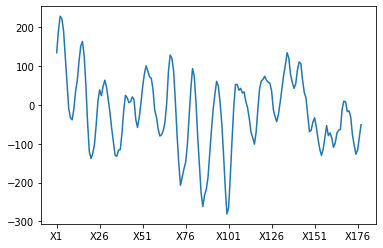

In [5]:
df.iloc[0, 1:-1].plot()

И случайный сигнал при судорогах:

<AxesSubplot:>

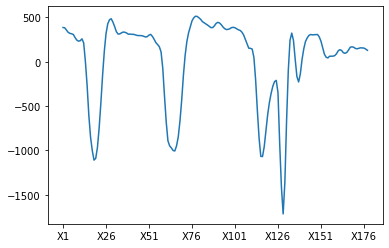

In [6]:
df.iloc[1, 1:-1].plot()

In [7]:
df.y.value_counts()

4    2300
1    2300
5    2300
2    2300
3    2300
Name: y, dtype: int64

Данные сбалансированы, но нам нужно только 2 класса

In [8]:
df['target'] = df.y.apply(lambda x: 0 if x != 1 else 1)

In [9]:
train, test = train_test_split(df, test_size=0.2, stratify=df.y, random_state=123)

In [10]:
X_train, X_test = train.iloc[:, 1:-2].values, test.iloc[:, 1:-2].values
y_train, y_test = train.target.values, test.target.values

In [11]:
X_train.shape

(9200, 178)

## 2. Baseline

Для всех алгоритмов будем использовать RandomForest с одинаковыми параметрами

In [12]:
base = RandomForestClassifier(max_depth=5)
base.fit(X_train, y_train)
base_preds = base.predict(X_test)

In [26]:
def get_main_metrics(preds, y_test):
    print(f"Accuracy score: {accuracy_score(y_test, preds):.4f}")
    print(f"F1 score: {f1_score(y_test, preds):.4f}")
    print("Confusion matrix:")
    plt.figure(figsize=(5, 3))
    sns.heatmap(confusion_matrix(y_test, preds), annot=True, fmt="d", cbar=False)
    plt.ylabel('True label', fontsize = 14)
    plt.xlabel('Predicted label', fontsize = 14)
    plt.show()

Accuracy score: 0.9504
F1 score: 0.8606
Confusion matrix:


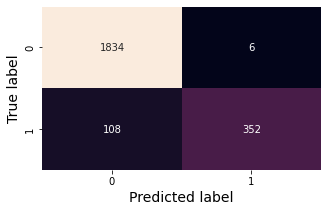

In [14]:
get_main_metrics(base_preds, y_test)

Сильно выраженное смещение в сторону ложноотрицательных предсказаний.

## 3. FFT

Для начала убедимся, что fft работает так, как и ожидается

In [30]:
N = X_train.shape[1]
t_n = 1
T = t_n / N

Случайный периодический сигнал, а котором явно выделены 4 экстремума

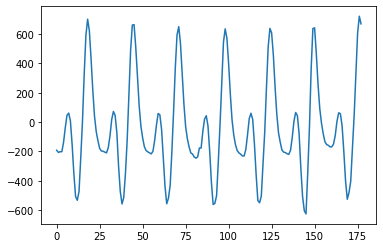

In [31]:
plt.plot(X_train[1, :])

На графике частот и амплитуд видно соответственно 4 пика

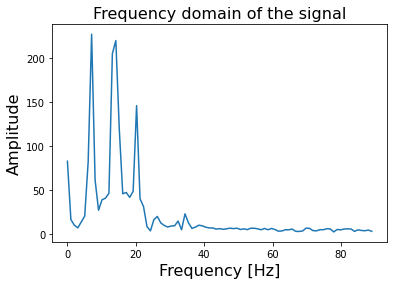

In [33]:
def get_fft_values(y_values, T, N):  
    f_values = np.linspace(0.0, 1.0 / (2.0 * T), N // 2)
    fft_values_ = fft(y_values)
    fft_values = 2.0 / N * np.abs(fft_values_[0: N // 2])
    return f_values, fft_values

f_values, fft_values = get_fft_values(X_train[1, :], T, N)

plt.plot(f_values, fft_values)
plt.xlabel('Frequency [Hz]', fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.title("Frequency domain of the signal", fontsize=16)
plt.show()

### 3.1. Using full fft values

В лекции в качестве признаков использовались только пики амплитуд и частот при нескольких преобразованиях исходного сигнала. Для начала посмотрим, что будет, если использовать полные значения амплитуд при преобразовании Фурье

In [18]:
X_train_fft = np.asarray([get_fft_values(x, T, N)[1] for x in X_train])
X_test_fft = np.asarray([get_fft_values(x, T, N)[1] for x in X_test])

In [19]:
fft_forest = RandomForestClassifier(max_depth=5)
fft_forest.fit(X_train_fft, y_train)
fft_preds = fft_forest.predict(X_test_fft)

Accuracy score: 0.9752
F1 score: 0.9362
Confusion matrix:


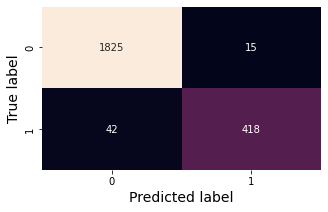

In [20]:
get_main_metrics(fft_preds, y_test)

По сравнению с бейслайномм скоры выросли, предсказания более сбалансированы

### 3.2. Using peaks

Теперь же использую только значения в пиках, испоьзуя пакет scipy

In [21]:
peaks, _ = find_peaks(fft_values)

In [22]:
peaks[:10]

array([ 7, 14, 17, 20, 26, 32, 34, 38, 44, 47])

In [23]:
np.argsort(fft_values)[::-1][:10]

array([ 7, 14, 13, 20, 15,  0,  6,  8, 19, 17])

In [24]:
def extract_features(signal, n_peaks=10):
    f_values, fft_values = get_fft_values(signal, T, N)
    peaks, _ = find_peaks(fft_values)
    x, y = f_values[peaks[:n_peaks]], fft_values[peaks[:n_peaks]]
    if len(peaks) < n_peaks:
        n_miss = n_peaks - len(peaks)
        x = np.concatenate((x, np.asarray([0] * n_miss)))
        y = np.concatenate((y, np.asarray([0] * n_miss)))
    return np.concatenate((x, y))

In [25]:
extract_features(X_train[1, :])

array([  7.07954545,  14.15909091,  17.19318182,  20.22727273,
        26.29545455,  32.36363636,  34.38636364,  38.43181818,
        44.5       ,  47.53409091, 227.44075589, 220.26781632,
        47.54029579, 146.24538078,  20.23470802,  15.04333796,
        23.20719928,  10.2854297 ,   6.4097417 ,   6.9491429 ])

In [26]:
X_train_peaks = np.asarray([extract_features(x) for x in X_train])
X_test_peaks = np.asarray([extract_features(x) for x in X_test])

In [27]:
peak_forest = RandomForestClassifier(max_depth=5)
peak_forest.fit(X_train_peaks, y_train)
peak_preds = peak_forest.predict(X_test_peaks)

Accuracy score: 0.9757
F1 score: 0.9372
Confusion matrix:


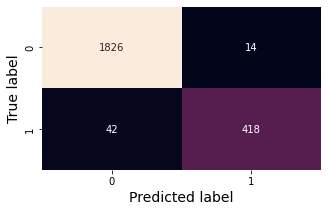

In [28]:
get_main_metrics(peak_preds, y_test)

Незначительно выросли скоры.

## 4. Wavelet transform

В лекции использовалась непрерывная трансформация только для демонстрации принципа, а на практике к данным HAR была применена дискретная трансформация с последующим извлечением признаков. Поэтому здесь будет использована continious-трансформация

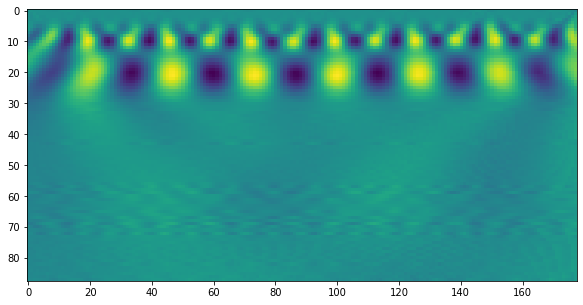

In [29]:
scale = np.arange(1, N // 2)
wavelet = 'morl'

coefficients, frequencies = pywt.cwt(X_train[1, :], scale, wavelet)
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(coefficients)

### 4.1. Flatten CWT + PCA

Самый простой вариант - уплощить векторы и уменьшить размерность

In [30]:
def get_flatten_cwt(X):
    result = []
    for x in tqdm(X):
        coef, _ = pywt.cwt(x, scale, wavelet)
        result.append(coef.flatten())
    return np.asarray(result)

In [31]:
X_train_cwt = get_flatten_cwt(X_train)
X_test_cwt = get_flatten_cwt(X_test)

  0%|          | 0/9200 [00:00<?, ?it/s]

  0%|          | 0/2300 [00:00<?, ?it/s]

In [32]:
X_train_cwt.shape

(9200, 15664)

In [55]:
pca = PCA(n_components=32)

In [56]:
%%time
X_train_pca = pca.fit_transform(X_train_cwt)

CPU times: user 43 s, sys: 3.52 s, total: 46.6 s
Wall time: 7.39 s


In [57]:
X_test_pca = pca.transform(X_test_cwt)

In [58]:
cwt_forest = RandomForestClassifier(max_depth=5)
cwt_forest.fit(X_train_pca, y_train)
cwt_preds = cwt_forest.predict(X_test_pca)

Accuracy score: 0.9530
F1 score: 0.8729
Confusion matrix:


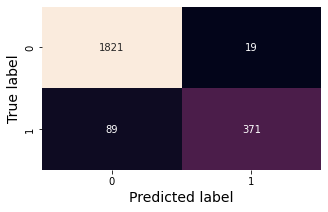

In [59]:
get_main_metrics(cwt_preds, y_test)

Результаты хуже, чем у трансформации Фурье

### 4.2. Standard CNN

Возможно, применение классических сверток, как при работе с изображениями, может улучшить модель. Для этого проще всего сделать векторы квадратными.

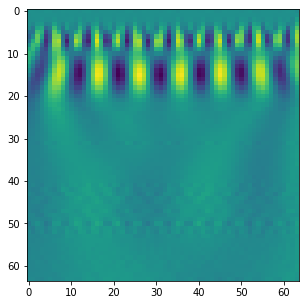

In [71]:
resized_cwt = resize(coefficients, (64, 64))
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(resized_cwt)

In [101]:
def get_resized_cwt(X):
    result = []
    for x in tqdm(X):
        coef, _ = pywt.cwt(x, scale, wavelet)
        result.append(resize(coef, (1, 64, 64)))
    return np.asarray(result)

In [102]:
X_train_cwt = get_resized_cwt(X_train)
X_test_cwt = get_resized_cwt(X_test)

  0%|          | 0/9200 [00:00<?, ?it/s]

  0%|          | 0/2300 [00:00<?, ?it/s]

In [279]:
X_train_cwt.shape

(9200, 1, 64, 64)

In [313]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=5)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(2704, 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 2704)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)

In [320]:
cnn = CNN()
optimizer = optim.SGD(cnn.parameters(), lr=1e-3, momentum=0.7)

In [321]:
batch_size = 32

X_train_tensor = torch.tensor(X_train_cwt, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.int64)

X_test_tensor = torch.tensor(X_test_cwt, dtype=torch.float)
y_test_tensor = torch.tensor(y_test, dtype=torch.int64)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size)
test_loader = DataLoader(test_dataset, batch_size)

In [322]:
train_losses, test_losses, accuracies = [], [], []

def train_nn(epoch):
    cnn.train()
    for batch_idx, (sample, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = cnn(sample)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    print('Train Epoch: {}, Loss: {:.6f}'.format(epoch, loss.item()))

def test_nn():
    cnn.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for sample, target in test_loader:
            output = cnn(sample)
            test_loss += F.cross_entropy(output, target, size_average=False).item()
            pred = np.argmax(output.detach().numpy(), -1)
            correct += np.where(target.detach().numpy() == pred)[0].shape[0]
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    accuracies.append(100. * correct / len(test_loader.dataset))
    print('Test loss: {:.4f}, Accuracy: {:.0f}%'.format(
        test_loss, 100. * correct / len(test_loader.dataset)))

In [323]:
test_nn()
for epoch in range(10):
    train_nn(epoch)
    test_nn()

/Users/bryl/projects/venv/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Test loss: 2.1231, Accuracy: 72%
Train Epoch: 0, Loss: 0.482653
Test loss: 0.4585, Accuracy: 93%
Train Epoch: 1, Loss: 0.398128
Test loss: 0.3729, Accuracy: 94%
Train Epoch: 2, Loss: 0.289477
Test loss: 0.3285, Accuracy: 94%
Train Epoch: 3, Loss: 0.267123
Test loss: 0.3028, Accuracy: 94%
Train Epoch: 4, Loss: 0.248554
Test loss: 0.2729, Accuracy: 95%
Train Epoch: 5, Loss: 0.163874
Test loss: 0.2525, Accuracy: 94%
Train Epoch: 6, Loss: 0.174154
Test loss: 0.2417, Accuracy: 94%
Train Epoch: 7, Loss: 0.162898
Test loss: 0.2275, Accuracy: 94%
Train Epoch: 8, Loss: 0.140971
Test loss: 0.2211, Accuracy: 93%
Train Epoch: 9, Loss: 0.173795
Test loss: 0.2106, Accuracy: 94%


In [324]:
cnn_preds = np.asarray([])
cnn.eval()
with torch.no_grad():
    for sample, target in test_loader:
        output = cnn(sample)
        pred = np.argmax(output.detach().numpy(), -1)
        cnn_preds = np.concatenate((cnn_preds, pred))

Accuracy score: 0.9361
F1 score: 0.8103
Confusion matrix:


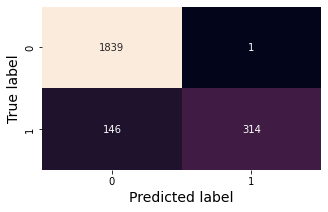

In [325]:
get_main_metrics(cnn_preds, y_test)

Результаты опустились к показателям бейзлайна - низкий скор и смещение предсказаний. Возможно, выбрана неудачная архитектура сети, а возможно, что на этапе трансформаций эмбеддингов потеряно слишком много данных.

## 5. TSFel

In [12]:
cfg = tsfel.get_features_by_domain('temporal')

In [13]:
import warnings
warnings.filterwarnings("ignore")

In [14]:
%%time
X_train_tsfel = tsfel.time_series_features_extractor(cfg, X_train, 100)
X_test_tsfel = tsfel.time_series_features_extractor(cfg, X_test, 100)

*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
CPU times: user 26.5 s, sys: 5.42 s, total: 31.9 s
Wall time: 38.4 s


In [19]:
corr_features = tsfel.correlated_features(X_train_tsfel)
X_train_tsfel.drop(corr_features, axis=1, inplace=True)
X_test_tsfel.drop(corr_features, axis=1, inplace=True)

In [23]:
selector = VarianceThreshold(0.9)
X_train_tsfel = selector.fit_transform(X_train_tsfel)
X_test_tsfel = selector.transform(X_test_tsfel)

In [24]:
X_train_tsfel.shape

(9200, 7)

In [25]:
tsfel_forest = RandomForestClassifier(max_depth=5)
tsfel_forest.fit(X_train_tsfel, y_train)
tsfel_preds = tsfel_forest.predict(X_test_tsfel)

Accuracy score: 0.9783
F1 score: 0.9439
Confusion matrix:


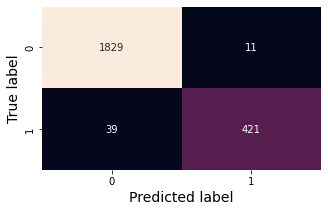

In [27]:
get_main_metrics(tsfel_preds, y_test)

Алгоритм автоматической генерации признаков показывает наилучшие результаты, даже с учетом отбора только 7 признаков